In [170]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from numpy.random import dirichlet as diri

dl = DataLib("SignalData")

In [183]:
# Pull all the necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
core_cpi = dl.pull("CoreCPI/SA")

In [172]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

# Overview
Here we look at using money supply as an indicator. 

Money supply is a tool for combatting inflation. Inflation affects bond prices in the following way: 
- inflation increases, interest rates rise to combat this, bond returns drop
- inflation decreases, interest rates can be lowered to stimulate the economy, bond returns increase

Money supply is increased to stimulate the economy, and it is restricted to prevent inflation. 

How should we expect it to behave? Let's have a look at the relationship between money supply and inflation. 

# Exploration


As we are trying to predict bond returns, let's see if we can discern a relationship between them. 

In [196]:
# Let's formulate what we want to use as money supply. 
M1_change = M1.pct_change()
M2_change = M2.pct_change()
M3_change = M3.pct_change()

# Use a combination of M1 and M3 for Australia (as it's missing M2). 
ms_chg = M2_change
ms_chg['AUS'] = 0.5 * M1_change['AUS'] + 0.5 * M3_change['AUS']

Let's use the change of the last 3 months compared to the change in the last 12 months. Smooth this difference. 

In [113]:
ms_chg_diff = ms_chg.rolling(3).mean() - ms_chg.rolling(12).mean()
ms_chg_diff_sma = ms_chg_diff.rolling(12).mean()

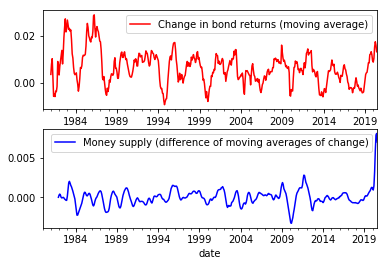

In [164]:
# Take the change in returns, then smooth. 
bri = BondRetIdx
bri_chg = bri.resample('M').mean().pct_change()
bri_chg_sma = bri_change.rolling(12).mean()

# Plot the change in returns alongside the change difference in MS. 
fig, axs = plt.subplots(2, 1)
bri_chg_sma['USA'].plot(ax=axs[0], color='red', label='Change in bond returns (moving average)')
axs[0].legend()
ms_chg_diff_sma['USA'].plot(ax=axs[1], color='blue', label='Money supply (difference of moving averages of change)')
axs[1].legend()

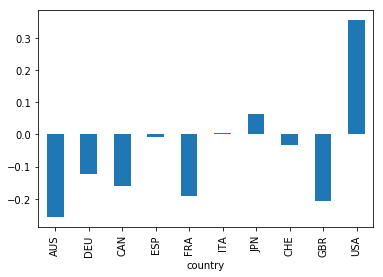

In [115]:
bri_chg_sma.corrwith(ms_chg_diff_sma).plot.bar()

Let's see if a relationship exists between inflation and money supply, as we posited at the beginning. 

In [147]:
core_cpi_chg = core_cpi.pct_change()
core_cpi_chg_sma = core_cpi_chg.rolling(12).mean()

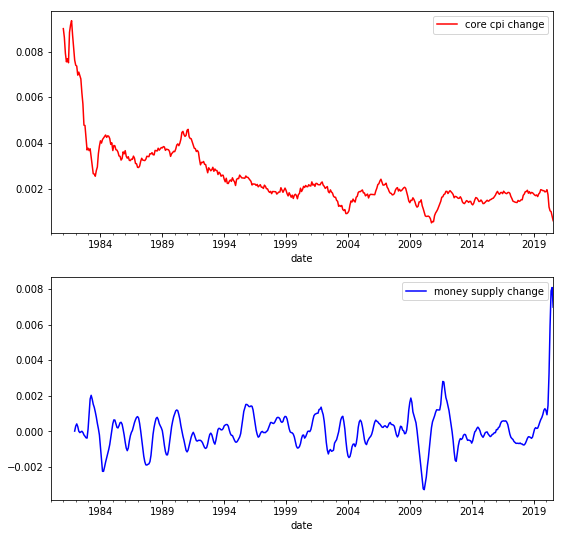

In [166]:
fig, axs = plt.subplots(2, 1, figsize=(9,9))
core_cpi_chg_sma['USA'].plot(ax=axs[0], color='red', label='core cpi change')
axs[0].legend()
ms_chg_diff_sma['USA'].plot(ax=axs[1], color='blue', label='money supply change')
axs[1].legend()

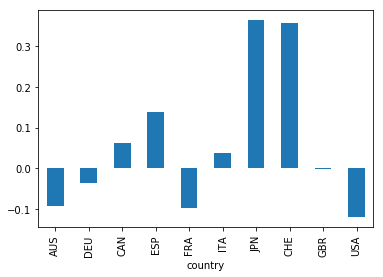

In [169]:
core_cpi_chg_sma.corrwith(ms_chg_diff_sma).plot.bar(label='correlation b/w core CPI change and money supply change')

# Build the indicator

In [202]:
# Get the mean across all countries of the 12-month rolling average of monthly change.
ms_chg_average = ms_chg.rolling(12*5).mean().mean(axis=1)

# Subtract this mean from the monthly change.
ms_chg_subglobal = ms_chg.subtract(ms_chg_average, axis=0)

# Turn the change into a zscore. 
sma = ms_chg_subglobal.rolling(12).mean()
std = ms_chg_subglobal.rolling(12).std()
zscore = (ms_chg_subglobal - sma) / std

# Return stream

`TODO`: should we be capping the zscore like this? 

In [203]:
# Convert the z-score to a signal by capping. 
signal = (-1 * zscore).clip(upper=2, lower=-2) / 2
signal = signal[signal.index < '2020-01-01']
signal = signal.resample('B').ffill()

In [204]:
bri_chg.index

PeriodIndex(['1980-01-01', '1980-01-02', '1980-01-03', '1980-01-04',
             '1980-01-07', '1980-01-08', '1980-01-09', '1980-01-10',
             '1980-01-11', '1980-01-14',
             ...
             '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
             '2020-07-24', '2020-07-27', '2020-07-28', '2020-07-29',
             '2020-07-30', '2020-07-31'],
            dtype='period[B]', name='date', length=10589, freq='B')

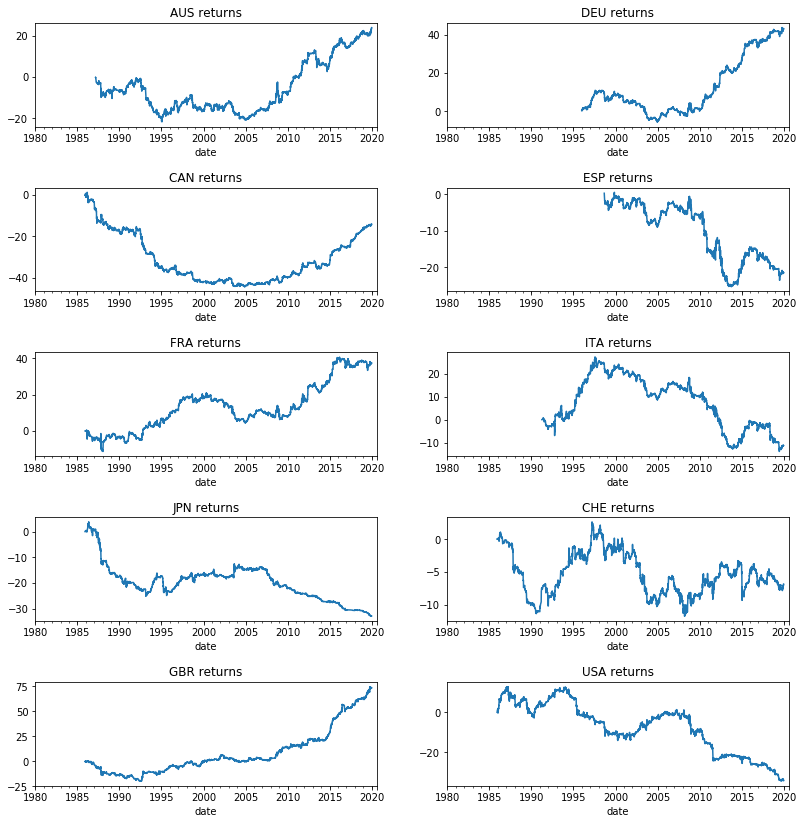

In [205]:
# Calculate the returns.
bri_chg = bri.pct_change().shift(-1)
returns = (signal * bri_chg)

# Plot the return stream for every country. 
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, country in enumerate(bri.columns.values):
    ax = axs[i//2][i%2]
    cumul_returns = ((returns[country] + 1).cumprod() - 1) * 100
    cumul_returns.plot(ax=ax, title='{} returns'.format(country))

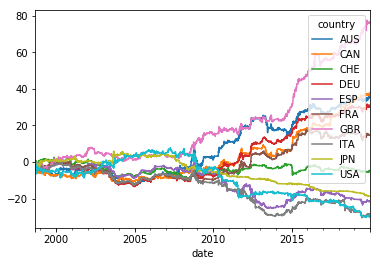

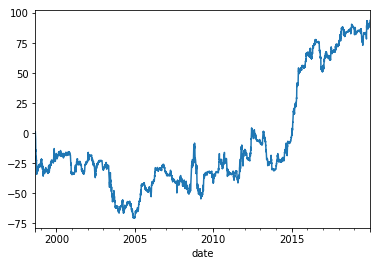

In [206]:
cumul_returns = ((returns.dropna() + 1).cumprod() - 1) * 100
cumul_returns.plot()
plt.show()
cumul_returns.sum(axis=1).plot()